In [28]:
import os

In [29]:
import torchvision
from torchvision import datasets ,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import random
import os
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [30]:
data_dir="/kaggle/input/chest-xray-pneumonia/chest_xray"

In [31]:
def data_transforms(flag=None):

    if flag=="train":
#         transform=transforms.Compose([
#             transforms.Resize(size=(224,224)),
#             transforms.RandomResizedCrop(224),
#             transforms.RandomHorizontalFlip(p=0.2),
#             transforms.RandomRotation(degrees=(-15,+15)),
#             transforms.TrivialAugmentWide(num_magnitude_bins=31),
#             transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4, hue=0.1),
#             transforms.ToTensor(),
#             transforms.Normalize([0.499, 0.499, 0.499],[0.499, 0.499, 0.499])

#         ])  
          # Define the image augmentations
            transform = transforms.Compose([
                transforms.RandomRotation(15),  # Rotate image by 15 degrees randomly
                transforms.RandomHorizontalFlip(),  # Random horizontal flip
                transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
                transforms.ToTensor(),  # Convert image to PyTorch tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
            ])

    elif flag=="test" or flag=="val":
#         transform=transforms.Compose([
#             transforms.Resize((224,224)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.499, 0.499, 0.499],[0.499, 0.499, 0.499])
#         ])
        transform = transforms.Compose([
            transforms.Resize(256),  # Resize the image to 256x256
            transforms.CenterCrop(224),  # Crop to 224x224 in the center
            transforms.ToTensor(),  # Convert image to PyTorch tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
        ])
    return transform


In [32]:
# Define transformations 

# Load the dataset
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms('train'))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [33]:
# Example: Accessing one batch of images and labels
images, labels = next(iter(train_dataloader))
print(images.shape, labels.shape)  # Print the shape of the batch

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [34]:
# now apply transformation on both test and validation datasets
test_dataset=datasets.ImageFolder(os.path.join(data_dir,"test"),transform=data_transforms('test'))
val_dataset=datasets.ImageFolder(os.path.join(data_dir,"val"),transform=data_transforms("val"))
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=32,shuffle=True)

In [35]:
# plot the image in each set 
train_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/test"
val_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/val"

classes = ['NORMAL', 'PNEUMONIA']

In [36]:
def num_of_images(dir):
    for label in classes:
        # number of image in each classs of the given directory
        class_dir=os.path.join(dir,label)
        num_images=len(os.listdir(class_dir))
        print(f"num of image  in {label} folder :{num_images} ")


In [37]:
type_=['train','test','validation']

In [38]:
i=0
for dir in [train_dir,test_dir,val_dir]:
  print(f"number of images in {type_[i]}")
  num_of_images(dir)
  print("\n")
  i+=1

number of images in train
num of image  in NORMAL folder :1341 
num of image  in PNEUMONIA folder :3875 


number of images in test
num of image  in NORMAL folder :234 
num of image  in PNEUMONIA folder :390 


number of images in validation
num of image  in NORMAL folder :8 
num of image  in PNEUMONIA folder :8 




In [39]:
# print some image and its label in each directory
def print_images(dir,num_samples):
  fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 5))
  for i, cls in enumerate(classes):
        class_dir = os.path.join(dir, cls)
        image_files = random.sample(os.listdir(class_dir), num_samples)
        for j, image_file in enumerate(image_files):
            img = mpimg.imread(os.path.join(class_dir, image_file))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)

  plt.show()

print image of train


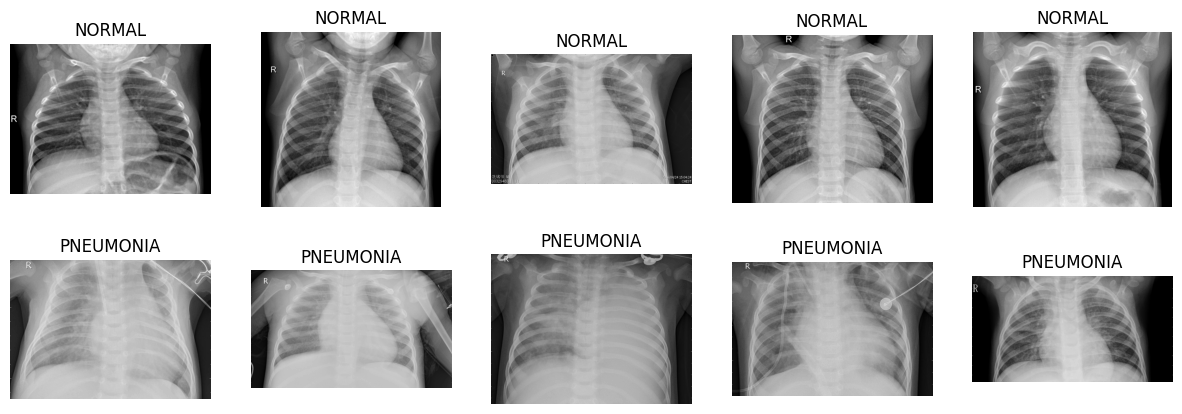



print image of test


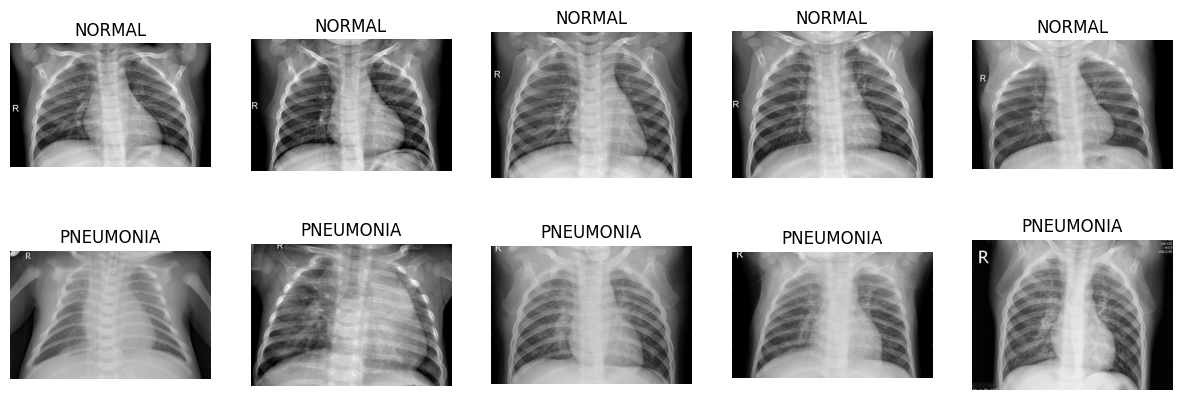



print image of validation


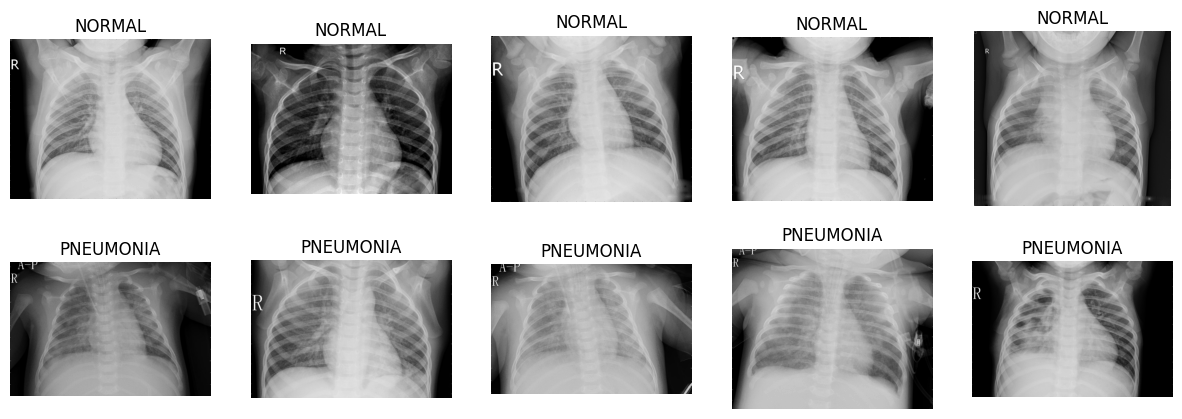

In [40]:
i=0
for dir in [train_dir,test_dir,val_dir]:
  print(f"print image of {type_[i]}")
  print_images(dir,5)
  i+=1
  print("\n")

In [41]:
# define device 

def get_device():
  device ="cuda" if torch.cuda.is_available() else "cpu"
  return device
  

In [42]:
device=get_device()

In [43]:
device

'cuda'

In [44]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dropout = nn.Dropout(0.4)  # Added dropout for regularization

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual  # Adding the residual connection
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after the residual connection

        return out

# Define the Custom ResNet architecture
class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):  # For binary classification (Pneumonia/Normal)
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Stacking Residual Blocks (Reduced number of blocks)
        self.layer1 = self._make_layer(64, 2)  # 2 blocks instead of the original ResNet's 3
        self.layer2 = self._make_layer(128, 2, stride=2)  # 2 blocks
        self.layer3 = self._make_layer(256, 2, stride=2)  # 2 blocks
        self.layer4 = self._make_layer(512, 2, stride=2)  # 2 blocks

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x




In [45]:
model=CustomResNet(num_classes=2)
model=model.to(device)

In [46]:
# initialize the training 
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [47]:
num_epochs=20

for epoch in range(num_epochs):
  model.train()

  training_loss=0
  correct_train = 0
  total_train = 0

  for images,labels in train_dataloader:
    images,labels=images.to(device),labels.to(device)

    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    training_loss+=loss.item()

    # Track accuracy
    _, predicted = torch.max(outputs, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)

  # total loss after one epoch
  train_loss = training_loss / len(train_dataloader)
  train_acc = 100 * correct_train / total_train


  # find validation loss 
  model.eval()
  val_loss=0.0
  correct_val=0
  total_val=0

  # stop gradient flow to validate the model
  with torch.no_grad():

    for images, labels in val_dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss= criterion(outputs, labels)
      val_loss +=loss.item()

      # Track validation accuracy
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      total_val += labels.size(0)

    val_loss = val_loss / len(val_dataloader)
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")





Epoch [1/20], Train Loss: 0.4741, Train Accuracy: 79.79%, Validation Loss: 0.6753, Validation Accuracy: 62.50%
Epoch [2/20], Train Loss: 0.4082, Train Accuracy: 81.46%, Validation Loss: 0.8935, Validation Accuracy: 50.00%
Epoch [3/20], Train Loss: 0.3904, Train Accuracy: 82.84%, Validation Loss: 1.1472, Validation Accuracy: 56.25%
Epoch [5/20], Train Loss: 0.3730, Train Accuracy: 83.49%, Validation Loss: 0.5039, Validation Accuracy: 68.75%
Epoch [6/20], Train Loss: 0.3619, Train Accuracy: 84.34%, Validation Loss: 0.8639, Validation Accuracy: 62.50%
Epoch [7/20], Train Loss: 0.3596, Train Accuracy: 83.93%, Validation Loss: 1.5353, Validation Accuracy: 62.50%
Epoch [8/20], Train Loss: 0.3334, Train Accuracy: 85.60%, Validation Loss: 0.9260, Validation Accuracy: 62.50%
Epoch [9/20], Train Loss: 0.3463, Train Accuracy: 84.87%, Validation Loss: 1.9157, Validation Accuracy: 56.25%
Epoch [10/20], Train Loss: 0.3288, Train Accuracy: 85.31%, Validation Loss: 0.7939, Validation Accuracy: 56.25%


In [64]:
# test the model 
def test_model(model,test_dataloader,device):
    model.eval()
    test_correct=0
    test_total=0
    test_loss=0.0
    
    preds_list=[]
    labels_list=[]
    
    with torch.no_grad():
        for images, labels, in test_dataloader:
            images,labels=images.to(device),labels.to(device)
            
            outputs=model(images).to(device)
            loss=criterion(outputs,labels)
            test_loss+=loss.item()

            _,predicted=torch.max(outputs,1)
            test_correct+=(predicted==labels).sum().item()
            test_total+=labels.size(0)
            
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(predicted.cpu().numpy())

        average_test_loss=test_loss/len(test_dataloader)
        test_accuracy=100*test_correct/test_total

    print(f"Test loss: {average_test_loss:.4f}| Test accuracy :{test_accuracy:.4f}")
    return preds_list,labels_list




In [65]:
prediction,lables=test_model(model=model,test_dataloader=test_dataloader,device=device)

Test loss: 0.4529| Test accuracy :86.2179


In [66]:
type(prediction)

list

In [60]:
torch.save(model.state_dict(),"chest_xray_model.pth")

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

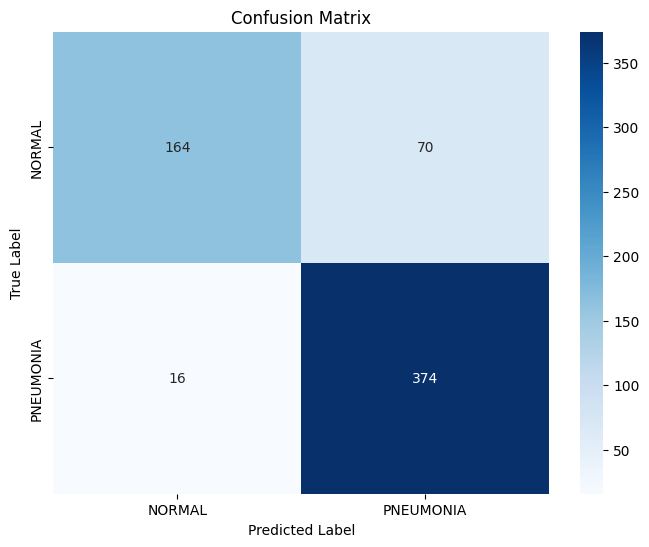

In [67]:
 # Compute confusion matrix
cm = confusion_matrix(lables,prediction)
classes = ['NORMAL', 'PNEUMONIA']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
# Calculate precision, recall, and F1 score
precision = precision_score(lables, prediction)
recall = recall_score(lables, prediction)
f1 = f1_score(lables, prediction)
accuracy=accuracy_score(lables, prediction)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"accuracy:{accuracy}")

Precision: 0.8423423423423423
Recall: 0.958974358974359
F1-score: 0.8968824940047961
accuracy:0.8621794871794872


[0.625      0.84234234 1.        ]
[1.         0.95897436 0.        ]


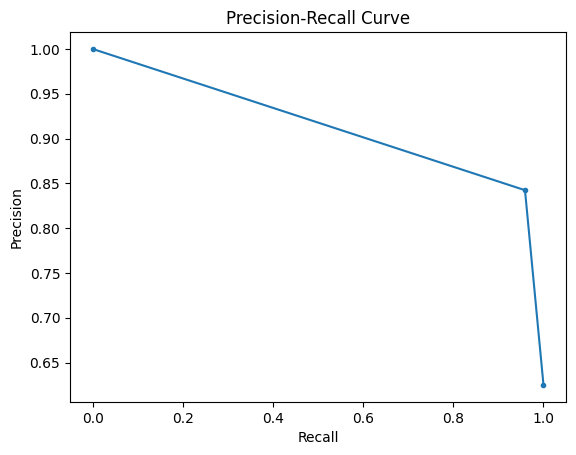

In [71]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(lables, prediction)
# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp =inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp =std *inp + mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

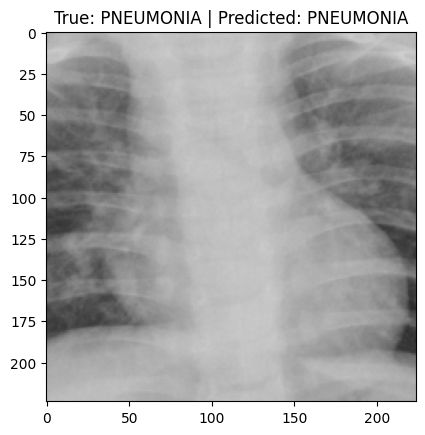

In [79]:
model.eval()

# Get class names from the test dataset
class_names = test_dataset.classes

# Predict and plot
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs
        labels = labels

        # Predict the label
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        imshow(inputs.cpu().data[0], title=f"True: {class_names[labels[0]]} | Predicted: {class_names[preds[0]]}")
        break